In [61]:
# Import Modules
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# import Data
pd.set_option('display.max_columns', None)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [63]:
# Check data quality
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


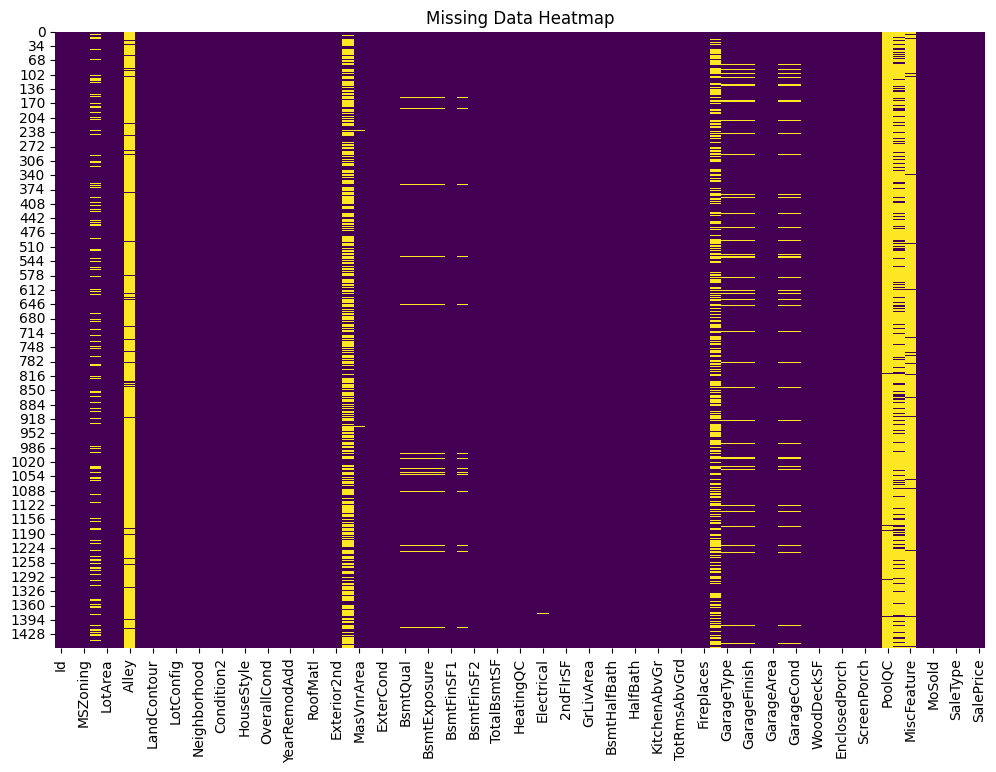

In [64]:
# Visualization: Missing Data Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

In [65]:
# Check for columns with more than 100 missing values and drop them
columns_to_drop = missing_values[missing_values > 100].index
train = train.drop(columns=columns_to_drop)

# print the columns that were dropped
print(f"Columns dropped: {list(columns_to_drop)}")

Columns dropped: ['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [66]:
# Encode the categorical data to be numerical
label_encoder = LabelEncoder()

# Automatically identify categorical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Apply label encoding to categorical columns
for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col].astype(str))

# Optional: print the list of encoded categorical columns
print(f"Encoded categorical columns: {list(categorical_columns)}")

Encoded categorical columns: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [67]:
# Handling Missing Data: inpute missing values using the median
train.fillna(train.median(), inplace=True)

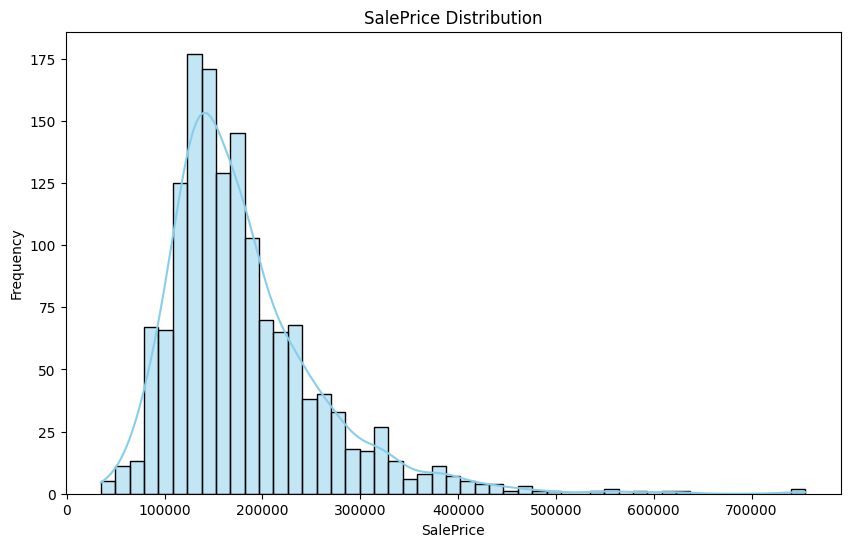

In [68]:
# Visualize the distribution of the target variable (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, color="skyblue")
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [69]:
# Feature Engineering
# 1. Age at Sale
train['AgeAtSale'] = train['YrSold'] - train['YearBuilt']
train['YearsSinceRemodel'] = train['YrSold'] - train['YearRemodAdd']

# 2. Total Bathrooms
train['TotalBaths'] = train['FullBath'] + train['HalfBath'] * 0.5 + train['BsmtFullBath'] + train['BsmtHalfBath'] * 0.5

# 3. Total Porch Area
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

In [70]:
# Define Features and Target -> Used the top 10 most important features as well as the engineered features
X = train[['OverallQual',
 'GrLivArea',
 '2ndFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 '1stFlrSF',
 'LotArea',
 'GarageArea',
 'GarageCars',
 'Neighborhood',
  # Engineered features
  'AgeAtSale',
  'YearsSinceRemodel',
  'TotalBaths',
  'TotalPorchSF']]  # Dropping Id and SalePrice (target variable)
y = train['SalePrice']

In [71]:
# Split Data into training and validation Set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [72]:
# Train the Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [73]:
# Evalute the Random Forest Model
y_pred = rf.predict(X_valid)

# RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"RMSE: {rmse}")

# R²
r2 = r2_score(y_valid, y_pred)
print(f"R²: {r2}")

# Explained Variance Score
evs = explained_variance_score(y_valid, y_pred)
print(f"Explained Variance Score: {evs}")

RMSE: 26713.915137521115
R²: 0.9069618106585867
Explained Variance Score: 0.9070178223755883


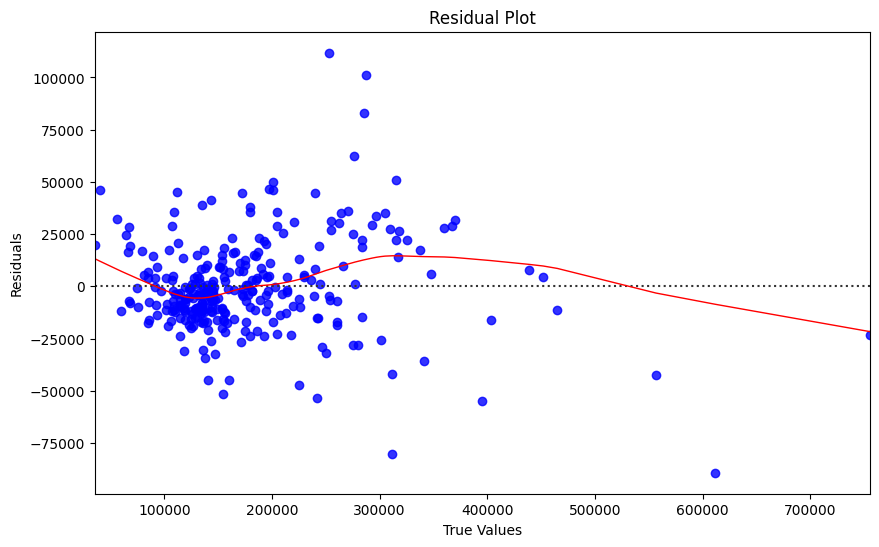

In [74]:
# Visualize the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_valid, y=y_pred, lowess=True, color="blue", line_kws={'color': 'red', 'lw': 1})
plt.title("Residual Plot")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

In [75]:
# Figure out which feature were the most important
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=["Importance"])
feature_importances.sort_values(by="Importance", ascending=False).head(10)

,Importance
OverallQual,0.564647
GrLivArea,0.131615
TotalBsmtSF,0.043705
2ndFlrSF,0.040837
BsmtFinSF1,0.036858
1stFlrSF,0.034857
LotArea,0.026630
GarageArea,0.023939
AgeAtSale,0.021274
TotalBaths,0.019601


<Figure size 1000x600 with 0 Axes>

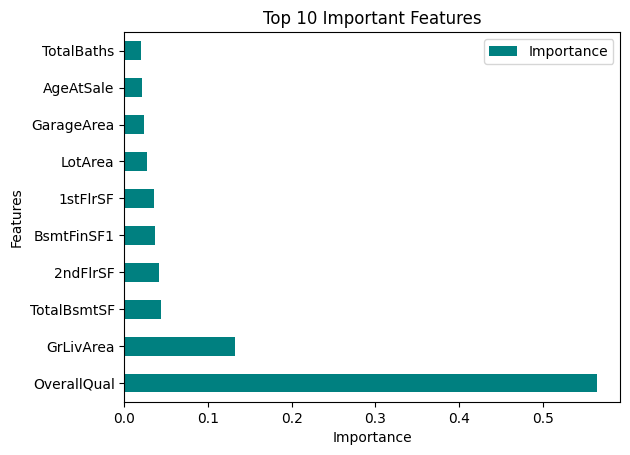

In [76]:
# Visualize the top 10 most important features
plt.figure(figsize=(10, 6))
feature_importances.sort_values(by="Importance", ascending=False).head(10).plot(kind="barh", color="teal")
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [77]:
# Prepare the test data

# Feature Engineering
# 1. Age at Sale
test['AgeAtSale'] = test['YrSold'] - test['YearBuilt']
test['YearsSinceRemodel'] = test['YrSold'] - test['YearRemodAdd']

# 2. Total Bathrooms
test['TotalBaths'] = test['FullBath'] + test['HalfBath'] * 0.5 + test['BsmtFullBath'] + test['BsmtHalfBath'] * 0.5

# 3. Total Porch Area
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

X_test = test[['OverallQual',
 'GrLivArea',
 '2ndFlrSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 '1stFlrSF',
 'LotArea',
 'GarageArea',
 'GarageCars',
 'Neighborhood',
  # Engineered features
  'AgeAtSale',
  'YearsSinceRemodel',
  'TotalBaths',
  'TotalPorchSF']]

# Ensure the test data has the same columns as the training data
common_cols = X.columns.intersection(X_test.columns)
X_test = X_test[common_cols]  # Keep only the common columns

# Automatically identify categorical columns
categorical_columns = X_test.select_dtypes(include=['object', 'category']).columns

# Apply label encoding to categorical columns
for col in categorical_columns:
    X_test[col] = label_encoder.fit_transform(X_test[col].astype(str))

# Handle missing values
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = np.nan
X_test = X_test[X.columns]

In [78]:
# make predictions
y_test_pred = rf.predict(X_test)

# Prepare the submission
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_test_pred
})

submission

,Id,SalePrice
0,1461,123583.33
1,1462,150212.50
2,1463,174849.85
3,1464,182983.00
4,1465,203294.56
...,...,...
1454,2915,85713.25
1455,2916,92051.75
1456,2917,161249.87
1457,2918,118792.75
